In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from sklearn.multioutput import MultiOutputRegressor


In [4]:
import glob
import os

# Data Loading

In [5]:
from pathlib import Path

# Check if /kaggle/input exists to determine if running on Kaggle
if os.path.exists("/kaggle/input"):
    # On Kaggle notebook
    DATA_DIR = Path("/kaggle/input/nfl-big-data-bowl-2026-prediction")
else:
    # On local PC
    DATA_DIR = Path("nfl-big-data-bowl-2026-prediction")

# DATA_DIR = Path("nfl-big-data-bowl-2026-prediction")

# Load all CSV files from train folder
train_input_files = sorted(glob.glob(str(DATA_DIR /'train'/'input_*.csv')))
train_output_files = sorted(glob.glob(str(DATA_DIR /'train'/'output_*.csv')))

print(f'Input files: {len(train_input_files)}')
print(f'Output files: {len(train_output_files)}')

Input files: 18
Output files: 18


# Data Preprocessing

In [6]:
# Combine data
input_dfs = []
output_dfs = []

for input_file, output_file in zip(train_input_files, train_output_files):
    input_df = pd.read_csv(input_file)
    output_df = pd.read_csv(output_file)
    input_dfs.append(input_df)
    output_dfs.append(output_df)

train_input = pd.concat(input_dfs, ignore_index=True)
train_output = pd.concat(output_dfs, ignore_index=True)

print(f'Train input shape: {train_input.shape}')
print(f'Train output shape: {train_output.shape}')

Train input shape: (4880579, 23)
Train output shape: (562936, 6)


In [7]:
# Data Inspection
print("Input columns:")
print(train_input.columns.tolist())
print("\nOutput columns:")
print(train_output.columns.tolist())
print("\nInput sample:")
display(train_input.head())
print("\nOutput sample:")
display(train_output.head())

Input columns:
['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y']

Output columns:
['game_id', 'play_id', 'nfl_id', 'frame_id', 'x', 'y']

Input sample:


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22



Output sample:


,game_id,play_id,nfl_id,frame_id,x,y
0,2023090700,101,46137,1,56.22,17.28
1,2023090700,101,46137,2,56.63,16.88
2,2023090700,101,46137,3,57.06,16.46
3,2023090700,101,46137,4,57.48,16.02
4,2023090700,101,46137,5,57.91,15.56


In [8]:
def create_advanced_features(df):
    """Create comprehensive feature set for optimal prediction"""
    df = df.copy()

    # Ball-related features
    df['dist_to_ball_land'] = np.sqrt(
        (df['x'] - df['ball_land_x'])**2 +
        (df['y'] - df['ball_land_y'])**2
    )

    df['angle_to_ball'] = np.arctan2(
        df['ball_land_y'] - df['y'],
        df['ball_land_x'] - df['x']
    )

    df['angle_to_ball_deg'] = np.degrees(df['angle_to_ball'])

    df['speed_to_ball'] = df['s'] * np.cos(
        np.radians(df['dir']) - df['angle_to_ball']
    )

    df['delta_x_to_ball'] = df['ball_land_x'] - df['x']
    df['delta_y_to_ball'] = df['ball_land_y'] - df['y']
    df['manhattan_dist_to_ball'] = np.abs(df['delta_x_to_ball']) + np.abs(df['delta_y_to_ball'])
    df['eucl_dist_to_ball'] = np.sqrt((df['ball_land_x'] - df['x'])**2 + (df['ball_land_y'] - df['y'])**2)
    df['x_y_dist_ratio'] = np.abs(df['delta_x_to_ball']) / (np.abs(df['delta_y_to_ball']) + 0.1)

    # Role encoding
    role_map = {
        'Targeted Receiver': 4,
        'Defensive Coverage': 3,
        'Other Route Runner': 2,
        'Passer': 1
    }
    df['role_encoded'] = df['player_role'].map(role_map).fillna(0)

    df['is_offense'] = (df['player_side'] == 'Offense').astype(int)
    df['is_targeted'] = (df['player_role'] == 'Targeted Receiver').astype(int)
    df['is_defender'] = (df['player_role'] == 'Defensive Coverage').astype(int)
    df['is_passer'] = (df['player_role'] == 'Passer').astype(int)

    # Field position
    df['field_position'] = df['absolute_yardline_number']
    df['play_dir_encoded'] = (df['play_direction'] == 'right').astype(int)

    df['dist_from_left_sideline'] = df['y']
    df['dist_from_right_sideline'] = 53.3 - df['y']
    df['dist_from_nearest_sideline'] = np.minimum(
        df['dist_from_left_sideline'],
        df['dist_from_right_sideline']
    )
    df['dist_from_endzone'] = np.minimum(df['x'], 120 - df['x'])

    # Velocity and acceleration components
    df['vx'] = df['s'] * np.cos(np.radians(df['dir']))
    df['vy'] = df['s'] * np.sin(np.radians(df['dir']))
    df['ax'] = df['a'] * np.cos(np.radians(df['dir']))
    df['ay'] = df['a'] * np.sin(np.radians(df['dir']))
    df['speed_squared'] = df['s'] ** 2
    df['accel_squared'] = df['a'] ** 2

    # Orientation features
    df['orientation_dir_diff'] = np.abs(df['o'] - df['dir'])
    df['orientation_dir_diff'] = np.where(
        df['orientation_dir_diff'] > 180,
        360 - df['orientation_dir_diff'],
        df['orientation_dir_diff']
    )
    df['facing_ball'] = (df['orientation_dir_diff'] < 90).astype(int)

    # Physics-based features
    df['expected_time_to_ball'] = df['dist_to_ball_land'] / (df['s'] + 0.1)
    df['frames_after_ball'] = df['num_frames_output'] - (df['expected_time_to_ball'] * 10)

    df['estimated_x_next'] = df['x'] + df['vx'] * 0.1
    df['estimated_y_next'] = df['y'] + df['vy'] * 0.1
    df['estimated_x_1sec'] = df['x'] + df['vx']
    df['estimated_y_1sec'] = df['y'] + df['vy']

    df['can_reach_ball'] = (df['expected_time_to_ball'] < df['num_frames_output'] * 0.1).astype(int)

    # Kinetic energy proxy
    df['kinetic_energy'] = 0.5 * df['speed_squared']

    # Trajectory curvature proxy
    df['velocity_angle'] = np.arctan2(df['vy'], df['vx'])
    df['trajectory_alignment'] = np.abs(df['velocity_angle'] - df['angle_to_ball'])

    return df
     
def add_sequence_features(df, window=3):
    """Add temporal sequence features"""
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])

    # Velocity changes
    df['delta_vx'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['vx'].diff()
    df['delta_vy'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['vy'].diff()
    df['delta_speed'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['s'].diff()

    # Acceleration changes (jerk)
    df['delta_ax'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['ax'].diff()
    df['delta_ay'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['ay'].diff()

    # Rolling statistics
    for col in ['s', 'a', 'vx', 'vy']:
        df[f'{col}_rolling_mean'] = df.groupby(['game_id', 'play_id', 'nfl_id'])[col].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        df[f'{col}_rolling_std'] = df.groupby(['game_id', 'play_id', 'nfl_id'])[col].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )

    df.fillna(0, inplace=True)

    return df
     
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """Wrapper function to apply all feature engineering steps"""
    print("Creating advanced features...")
    df = create_advanced_features(df)
    print("Adding sequence features...")
    df = add_sequence_features(df)
    print("Feature engineering complete.")
    return df

def height_to_inches(h):
    """Converts height string (e.g., '6-1') to inches"""
    try:
        f, i = h.split("-")
        return int(f) * 12 + int(i)
    except:
        return np.nan

# Data Processing & Feature Engineering

In [9]:
# 1. Apply feature engineering to the *entire* input dataset
engineered_df = engineer_features(train_input)
     
# 2. Filter for only the players we need to predict
players2predict = engineered_df[engineered_df["player_to_predict"] == True].copy()
print(f'Filtered (players to predict) shape: {players2predict.shape}')

# 3. Merge with output data to get target variables
#    This creates x_input, y_input, x_output, y_output
merged = players2predict.merge(
    train_output,
    on=["game_id", "play_id", "nfl_id", "frame_id"],
    suffixes=("_input", "_output")
)
print(f'Merged data shape: {merged.shape}')

# 4. Apply remaining non-sequential features
merged["player_height"] = merged["player_height"].apply(height_to_inches)

# Note: play_dir_encoded was already created in create_advanced_features
# merged["play_direction_encoded"] = (merged["play_direction"] == "right").astype(int)

# 5. Create dummy variables
position_dummies = pd.get_dummies(merged["player_position"], prefix="position")
role_dummies = pd.get_dummies(merged["player_role"], prefix="role")
merged = pd.concat([
    merged,
    position_dummies,
    role_dummies
], axis=1)

# 6. Define the final feature columns
# This list is generated from your provided snippet
feature_cols = [
    'absolute_yardline_number', 'player_weight', 'x_input', 'y_input', 's', 'a',
    'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y',
    'dist_to_ball_land', 'angle_to_ball', 'angle_to_ball_deg',
    'speed_to_ball', 'delta_x_to_ball', 'delta_y_to_ball',
    'manhattan_dist_to_ball', 'x_y_dist_ratio', 'eucl_dist_to_ball', # Added eucl_dist_to_ball
    'role_encoded', # Added role_encoded
    'is_offense', 'is_targeted', 'is_defender', 'is_passer',
    'field_position', 'play_dir_encoded', 'dist_from_left_sideline',
    'dist_from_right_sideline', 'dist_from_nearest_sideline',
    'dist_from_endzone', 'vx', 'vy', 'ax', 'ay', 'speed_squared',
    'accel_squared', 'orientation_dir_diff', 'facing_ball',
    'expected_time_to_ball', 'frames_after_ball', 'estimated_x_next',
    'estimated_y_next', 'estimated_x_1sec', 'estimated_y_1sec',
    'can_reach_ball', 'kinetic_energy', 'velocity_angle',
    'trajectory_alignment', 'delta_vx', 'delta_vy', 'delta_speed',
    'delta_ax', 'delta_ay', 's_rolling_mean', 's_rolling_std',
    'a_rolling_mean', 'a_rolling_std', 'vx_rolling_mean', 'vx_rolling_std',
    'vy_rolling_mean', 'vy_rolling_std',
    'player_height' # Added player_height
]
# Add dummy columns to feature list
feature_cols.extend([c for c in merged.columns if c.startswith(("position_", "role_"))])

# 7. Create final X and y
X = merged[feature_cols].fillna(0)
y = merged[["x_output","y_output"]]

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Creating advanced features...
Adding sequence features...
Feature engineering complete.
Filtered (players to predict) shape: (1303440, 74)
Merged data shape: (560426, 76)
Features shape: (560426, 83)
Target shape: (560426, 2)


# Data Split for training and testing

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')
print(f'Target shape: {y_train.shape} (samples, [x, y])')

Training set size: 392298
Test set size: 168128
Target shape: (392298, 2) (samples, [x, y])


# Model Training

In [12]:
random_forest_nfl = RF(n_estimators=100,
                   random_state=0, n_jobs=-1)
multi_output_booster = MultiOutputRegressor(estimator=random_forest_nfl)
multi_output_booster.fit(X_train, y_train)

,estimator,RandomForestR...andom_state=0)
,n_jobs,None
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


# Model Evaluation : Assessing Test and Training Data

In [13]:
# Predict on training and test data
y_hat_train = multi_output_booster.predict(X_train)
y_hat_test = multi_output_booster.predict(X_test)

# Calculate MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(f"Training Mean Squared Error (MSE): {train_mse}")
print(f"Test Mean Squared Error (MSE): {test_mse}")

# You can also calculate MSE per output (x and y)
train_mse_x = mean_squared_error(y_train[:, 0], y_hat_train[:, 0])
train_mse_y = mean_squared_error(y_train[:, 1], y_hat_train[:, 1])
test_mse_x = mean_squared_error(y_test[:, 0], y_hat_test[:, 0])
test_mse_y = mean_squared_error(y_test[:, 1], y_hat_test[:, 1])

print(f"\nTest MSE for X: {test_mse_x}")
print(f"Test MSE for Y: {test_mse_y}")

Training Mean Squared Error (MSE): 0.37188622263095267
Test Mean Squared Error (MSE): 2.588183228756665


InvalidIndexError: (slice(None, None, None), 0)

# Importance of features

In [14]:
# 1. Extract the feature importances from each fitted model inside the wrapper
all_importances = [
    estimator.feature_importances_ for estimator in multi_output_booster.estimators_
]

# 2. Average the importances across all models
# axis=0 calculates the mean down each column
average_importances = np.mean(all_importances, axis=0)

# 3. Create the DataFrame using the averaged importances
feature_names = X_train.columns.tolist()
feature_imp = pd.DataFrame(
    {'importance': average_importances},
    index=feature_names
)

# 4. Sort and display the results
print(feature_imp.sort_values(by='importance', ascending=False))

                            importance
ball_land_x               4.460096e-01
ball_land_y               3.805689e-01
estimated_y_next          3.374535e-02
dist_from_right_sideline  1.842249e-02
x_input                   1.408557e-02
...                                ...
position_NT               2.502525e-07
position_QB               1.904065e-07
position_LB               1.622852e-07
position_T                4.290553e-09
is_passer                 0.000000e+00

[83 rows x 1 columns]


In [15]:
y_hat_boost = multi_output_booster.predict(X_test)

mse = np.mean((y_test - y_hat_boost)**2)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2.588183228756665


# Data Visualisation of One tree

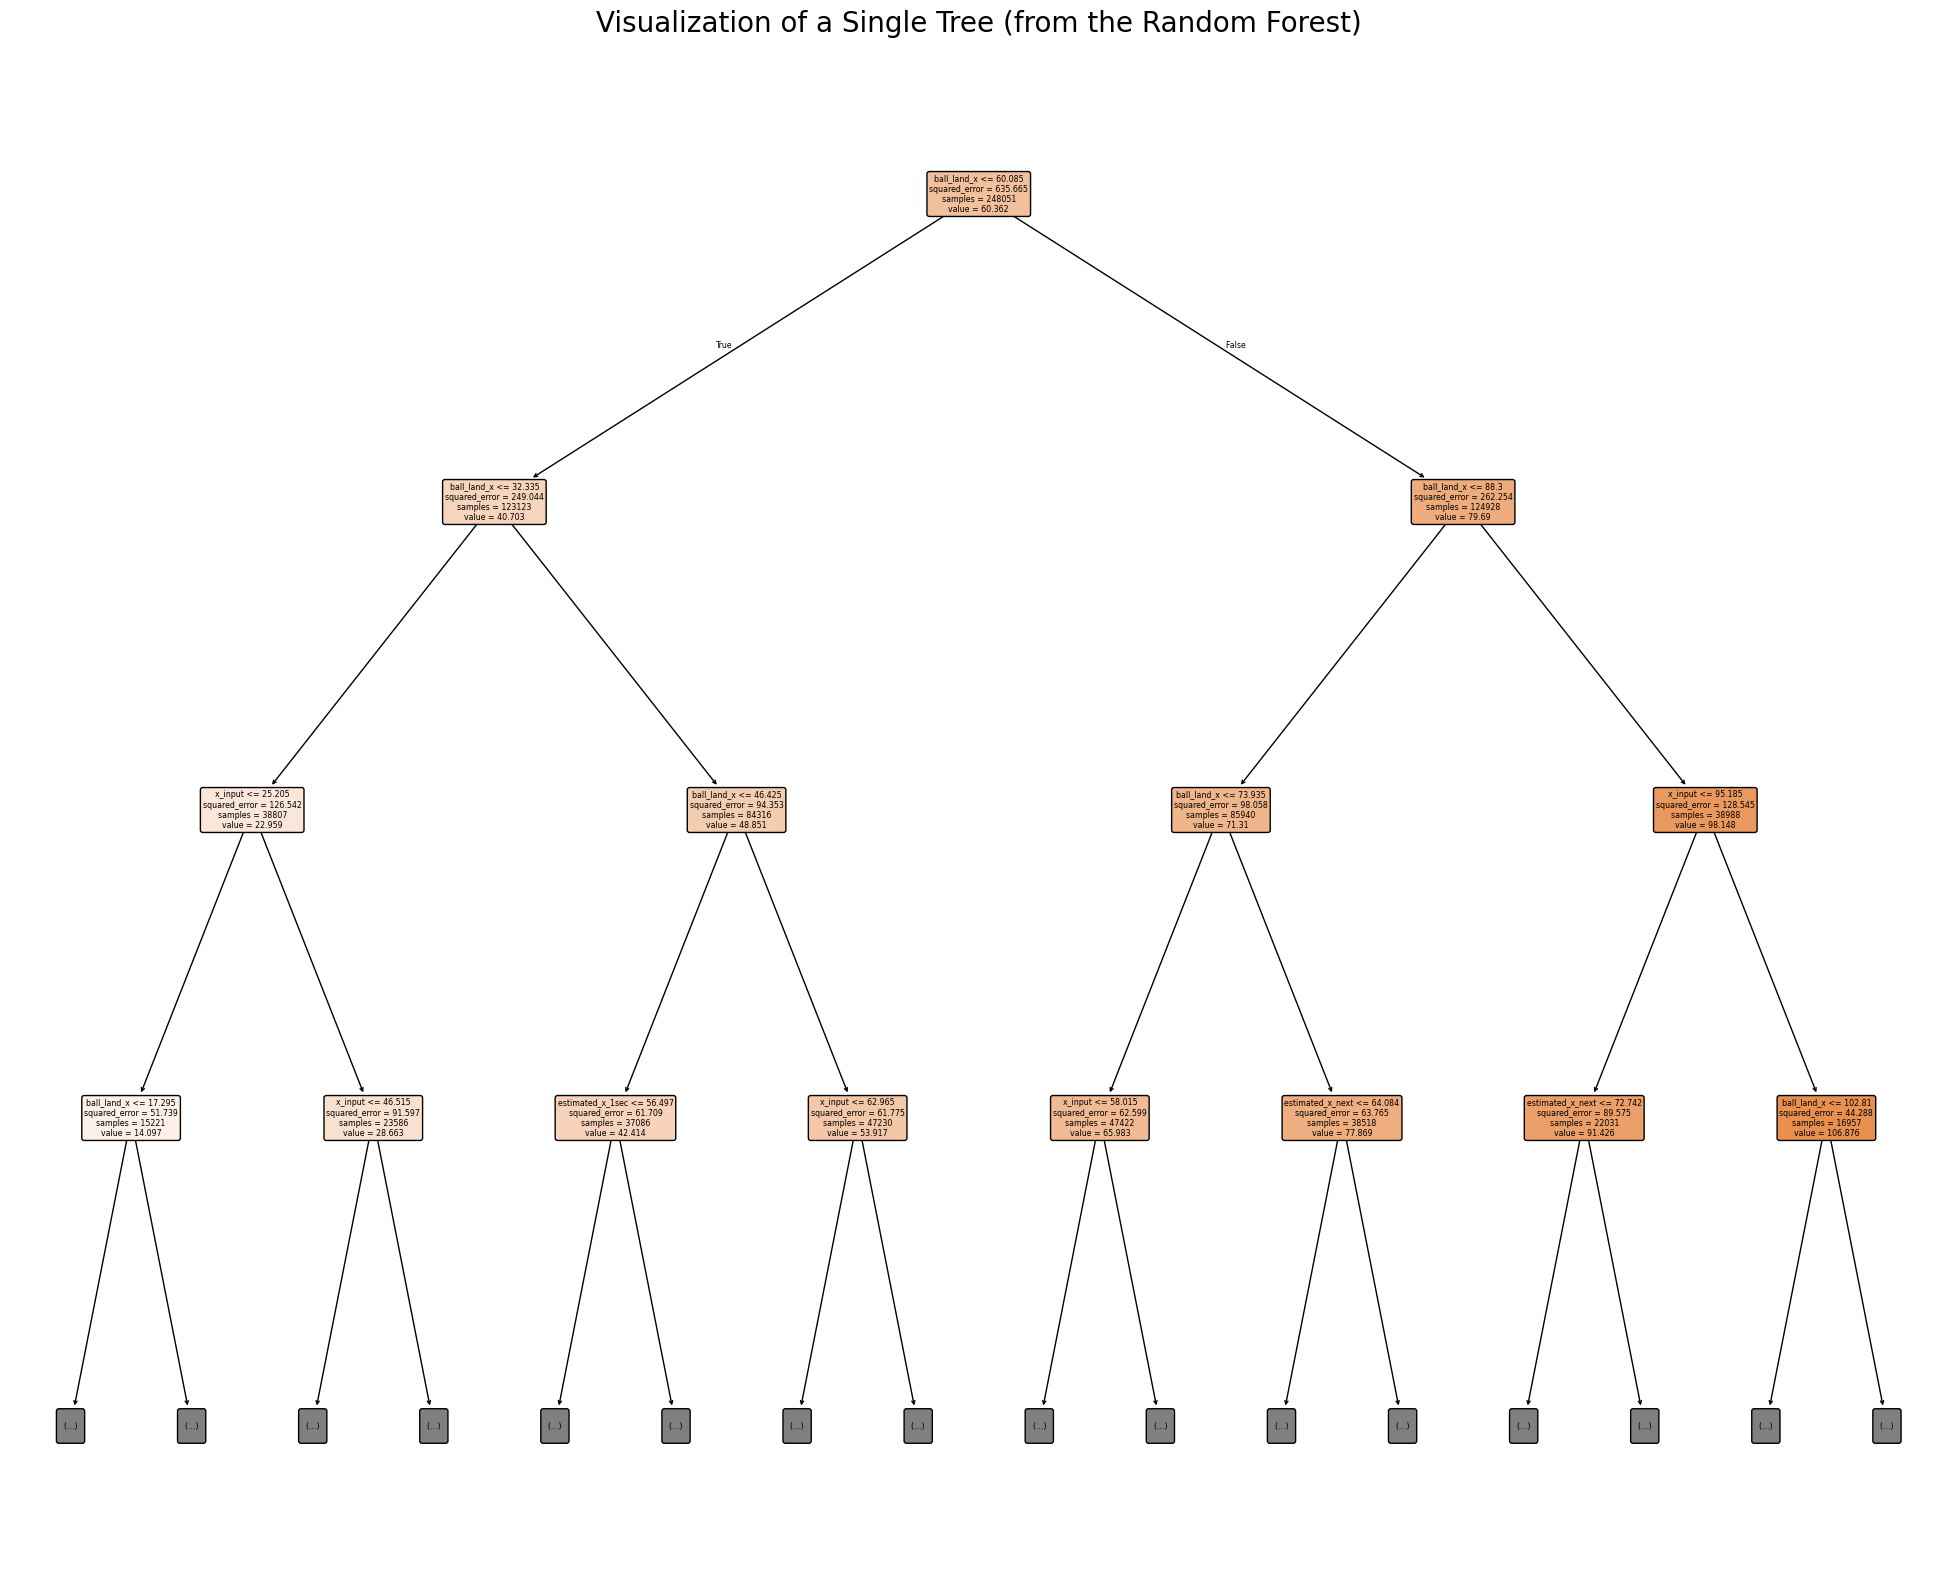

In [16]:
# 1. Get the Random Forest model for the first output (the x-coordinate)
rf_for_first_output = multi_output_booster.estimators_[0]

# 2. Pick one of the *individual trees* from that forest's .estimators_ list
#    Let's pick the first tree (index 0)
single_tree_from_forest = rf_for_first_output.estimators_[0]

# 3. Now, plot this single tree
plt.figure(figsize=(25, 20))
plot_tree(single_tree_from_forest, # <-- This is the corrected object
          feature_names=feature_names,
          filled=True,
          rounded=True,
          max_depth=3) # <-- max_depth in plot_tree is still useful

plt.title("Visualization of a Single Tree (from the Random Forest)", fontsize=20)
plt.show()

# Submission

In [ ]:
# %%
# --- Imports and API setup ---
import os
import pandas as pd
import polars as pl
import sys
from pathlib import Path

# 1. Add the evaluation API to the system path
# (Uses the DATA_DIR variable you defined in your "Data Loading" cell)
EVAL_DIR = DATA_DIR / 'kaggle_evaluation'
if str(EVAL_DIR) not in sys.path:
    sys.path.append(str(EVAL_DIR))

# Now these imports will work
import kaggle_evaluation.nfl_inference_server

# --- Prediction Function ---

def predict(test: pl.DataFrame, test_input: pl.DataFrame) -> pl.DataFrame | pd.DataFrame:
    """
    Generates predictions for the test set.
    This function is called by the evaluation API and must return a
    DataFrame in the submission format.
    
    It uses the globally trained 'multi_output_booster', 'feature_cols',
    'position_dummies', 'role_dummies', and the feature engineering functions.
    """
    print("API: Received prediction request...")
    
    # --- Convert Polars to Pandas ---
    test_input_df = test_input.to_pandas()
    test_df = test.to_pandas()
    
    # --- Helper Function (must be defined or available) ---
    def height_to_inches(h):
        try:
            f, i = h.split("-")
            return int(f) * 12 + int(i)
        except:
            return np.nan

    # 1. Feature Engineering (must match training data)
    #    This uses the globally defined engineer_features function
    #    and applies it to the *entire* test_input_df
    print("API: Performing full feature engineering...")
    engineered_df = engineer_features(test_input_df)
    
    # 2. Filter for only the players we need to predict
    players2predict = engineered_df[engineered_df["player_to_predict"] == True].copy()
    
    # 3. Apply post-merge/filtering features
    print("API: Applying secondary features...")
    players2predict['player_height'] = players2predict['player_height'].apply(height_to_inches)
    
    # 4. One-hot encode player_position and player_role
    print("API: Aligning dummy variable columns...")
    test_position_dummies = pd.get_dummies(players2predict['player_position'], prefix='position')
    test_role_dummies = pd.get_dummies(players2predict['player_role'], prefix='role')
    
    # Align dummy columns with training data
    # (Relies on 'position_dummies' and 'role_dummies' from training)
    for col in position_dummies.columns:
        if col not in test_position_dummies.columns:
            test_position_dummies[col] = 0
    test_position_dummies = test_position_dummies[position_dummies.columns] # Ensure same order
    
    for col in role_dummies.columns:
        if col not in test_role_dummies.columns:
            test_role_dummies[col] = 0
    test_role_dummies = test_role_dummies[role_dummies.columns] # Ensure same order
    
    # 5. Concatenate final features
    test_features = pd.concat([players2predict, test_position_dummies, test_role_dummies], axis=1)

    # 6. Feature selection (using the same 'feature_cols' list from training)
    #    This MUST be in the global scope from the training cell.
    #    We must rename 'x' and 'y' to 'x_input' and 'y_input' in our dataframe
    #    *before* selection, because 'feature_cols' expects them.
    #
    #    Correction: The merge in training created x_input/y_input.
    #    Here, we didn't merge. The `engineer_features` used 'x' and 'y'.
    #    The `feature_cols` list expects 'x_input' and 'y_input'.
    #    We must rename them.
    
    if 'x_input' not in test_features.columns:
        test_features = test_features.rename(columns={'x': 'x_input', 'y': 'y_input'})
        
    X_test_api = test_features[feature_cols].fillna(0)
    print(f'API: Test features shape: {X_test_api.shape}')

    # 7. Predict on test data
    print('API: Predicting test data...')
    # Uses the globally trained 'multi_output_booster'
    test_predictions = multi_output_booster.predict(X_test_api)
    test_pred_x = test_predictions[:, 0]
    test_pred_y = test_predictions[:, 1]
    
    # Add predictions back to the filtered dataframe
    players2predict['pred_x'] = test_pred_x
    players2predict['pred_y'] = test_pred_y

    # 8. NO INVERSION needed, as we did not standardize play direction
    
    # 9. Format the submission
    submission = test_df.copy()
    submission['id'] = submission['game_id'].astype(str) + '_' + \
                       submission['play_id'].astype(str) + '_' + \
                       submission['nfl_id'].astype(str) + '_' + \
                       submission['frame_id'].astype(str)
                       
    # Merge predictions
    test_pred_df = players2predict[['game_id', 'play_id', 'nfl_id', 'frame_id', 'pred_x', 'pred_y']].copy()
    
    submission = submission.merge(
        test_pred_df,
        on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
        how='left'
    )
    
    # 10. Return only 'x' and 'y' columns
    predictions_df = submission[['pred_x', 'pred_y']].rename(columns={'pred_x': 'x', 'pred_y': 'y'})
    
    # Fill missing values with 0 (for any rows in test_df we couldn't predict)
    predictions_df = predictions_df.fillna(0)
    
    print("API: Prediction request complete.")
    
    # Check assertions
    assert isinstance(predictions_df, (pd.DataFrame, pl.DataFrame))
    assert len(predictions_df) == len(test_df)
    
    # Return the DataFrame with *only* x and y
    return predictions_df

# --- Server Setup ---
# This code sets up and runs the server
inference_server = kaggle_evaluation.nfl_inference_server.NFLInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    print("Starting server for competition reruns...")
    inference_server.serve()
else:
    # This runs the local gateway for testing
    print("Running local gateway for testing...")
    inference_server.run_local_gateway((f'{DATA_DIR}',)) # Pass the DATA_DIR as the path

print("Submission process finished.")

Running local gateway for testing...
API: Received prediction request...
API: Standardizing play direction...
API: Performing feature engineering...
API: Aligning dummy variable columns...
API: Test features shape: (45, 38)
API: Predicting test data...
API: Inverting predictions for 'left' plays back to original coordinates...
API: Inversion complete.
API: Prediction request complete.
API: Received prediction request...
API: Standardizing play direction...
API: Performing feature engineering...
API: Aligning dummy variable columns...
API: Test features shape: (66, 38)
API: Predicting test data...
API: Inverting predictions for 'left' plays back to original coordinates...
API: Inversion complete.
API: Prediction request complete.
API: Received prediction request...
API: Standardizing play direction...
API: Performing feature engineering...
API: Aligning dummy variable columns...
API: Test features shape: (84, 38)
API: Predicting test data...
API: Inverting predictions for 'left' plays b